#Distance Estimator
To estimate the real distance(unit: meter) of the object

__Input__: Bounding box coordinates(xmin, ymin, xmax, ymax)   
__Output__: 3D location z of carmera coordinates(z_loc)

## Load Module

In [143]:
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import time
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader 
from sklearn.preprocessing import StandardScaler
from custom_datasets import CustomDataset
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [144]:
os.makedirs('./weights', exist_ok=True)

## Dataset

In [145]:
df_train = pd.read_csv('../datasets/kitti_train.csv')
df_valid = pd.read_csv('../datasets/kitti_valid.csv')
df_test = pd.read_csv('../datasets/kitti_test.csv')

In [146]:
df_train['class'].unique()

array(['person', 'car', 'truck', 'train', 'bicycle', 'Misc'], dtype=object)

In [147]:
# onehot encoding
class_dummy = pd.get_dummies(df_train['class'])
df_train = pd.concat([df_train, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_valid['class'])
df_valid = pd.concat([df_valid, class_dummy], axis=1)

class_dummy = pd.get_dummies(df_test['class'])
df_test = pd.concat([df_test, class_dummy], axis=1)

In [148]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22022 entries, 0 to 22021
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    22022 non-null  object 
 1   class       22022 non-null  object 
 2   xmin        22022 non-null  float64
 3   ymin        22022 non-null  float64
 4   xmax        22022 non-null  float64
 5   ymax        22022 non-null  float64
 6   angle       22022 non-null  float64
 7   zloc        22022 non-null  float64
 8   weather     22022 non-null  object 
 9   depth_y     22022 non-null  int64  
 10  depth_mean  22022 non-null  float64
 11  depth_x     22022 non-null  int64  
 12  depth_min   22022 non-null  float64
 13  width       22022 non-null  float64
 14  height      22022 non-null  float64
 15  Misc        22022 non-null  uint8  
 16  bicycle     22022 non-null  uint8  
 17  car         22022 non-null  uint8  
 18  person      22022 non-null  uint8  
 19  train       22022 non-nul

In [149]:
variable = ['xmin','ymin','xmax','ymax','width', 'height', 'depth_mean', 'depth_min', 'Misc', 'bicycle', 'car', 'person', 'train', 'truck']
batch_sz = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# train
train_dataset = CustomDataset(df_train, variable,True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)

# valid
valid_dataset = CustomDataset(df_valid, variable,True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sz, shuffle=True)

# train
test_dataset = CustomDataset(df_test, variable,True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_sz, shuffle=False)

In [150]:
# look dataset
for idx, batch in enumerate(train_dataloader):
    if idx == 1:
        break
    print(batch[0])
    print(batch[0].shape)
    print(batch[1])

tensor([[0.3866, 0.5618, 0.4316, 0.4002, 0.0850, 0.0960, 0.2926, 0.2762, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.3332, 0.5571, 0.3995, 0.5051, 0.1218, 0.1704, 0.2015, 0.1809, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.2676, 0.5544, 0.3203, 0.2898, 0.0983, 0.0292, 0.1989, 0.1422, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.5898, 0.4736, 0.5894, 0.1900, 0.0065, 0.0364, 0.1514, 0.1207, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3361, 0.4934, 0.3399, 0.1985, 0.0140, 0.0240, 0.6967, 0.2162, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3213, 0.5690, 0.3999, 0.4967, 0.1429, 0.1539, 0.1888, 0.1876, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.7583, 0.4549, 0.7963, 0.1902, 0.0726, 0.0537, 0.4242, 0.4163, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.2919, 0.5787, 0.3789, 0.5848, 0.1575, 0.2038, 0.1515, 0.1514, 0.0000,
  

In [151]:
# standardized data
#scalar = StandardScaler()
#X_train = scalar.fit_transform(X_train)
#y_train = scalar.fit_transform(y_train)

## Modeling

In [153]:
class DistanceEstimator(nn.Module):
    def __init__(self):
        super(DistanceEstimator, self).__init__()
        
        #Layer
        self.model = nn.Sequential(
            nn.Linear(14,32),
            nn.ReLU(),
            
            nn.Linear(32,64),
            nn.ReLU(),
            
            nn.Linear(64,128),
            nn.ReLU(),
            
            nn.Linear(128,256),
            nn.ReLU(),
            
            nn.Linear(256,512),
            nn.ReLU(),
            
            nn.Linear(512,1024),
            nn.ReLU(),
            
            nn.Linear(1024,512),
            nn.ReLU(),
            
            nn.Linear(512,256),
            nn.ReLU(),
            
            nn.Linear(256,128),
            nn.ReLU(),
            
            nn.Linear(128,64),
            nn.ReLU(),
            
            nn.Linear(64,32),
            nn.ReLU(),
            
            nn.Linear(32,16),
            nn.ReLU(),
            
            nn.Linear(16,1)
        )

    def forward(self, x):
        out = self.model(x)
        return out

## Make  variable

In [154]:
model = DistanceEstimator()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       patience = 8,
                                                       mode='min', # 우리는 낮아지는 값을 기대
                                                       verbose=True)

model.to(device)

DistanceEstimator(
  (model): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=1024, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=256, bias=True)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear(in_features=128, out_features=64, bias=True)
    (19): ReLU()
    (20): Linear(in_features=64, out_features=32, bias=True)
    (21): ReLU()
    (22): Linear(in_features=32, out_features=16, bias=True)
    (23): ReLU()
    (24): Linear

In [155]:
# train parameters
def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameter(model) # 87585

1400737

## Make Train, Valid function

In [156]:
def train(model, train_dataloader, idx_interval):
    model.train()
    
    train_loss = 0
    train_rmse = 0
    
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        prediction = model(batch[0].to(device))
        loss = loss_fn(prediction, batch[1].to(device)).cpu()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        train_rmse += np.sqrt(loss.item())
        
        if idx % idx_interval == 0:
            print("Train Epoch: {} [{}/{}] \t Train Loss(MSE): {:.4f} \t Train RMSE: {:.4f}".format(epoch, batch_sz*(idx+1), \
                                                                            len(train_dataloader)*batch_sz, \
                                                                            loss.item(), np.sqrt(loss.item())))
    
    train_loss /= len(train_dataloader)
    train_rmse /= len(train_dataloader)
        
    return train_loss, train_rmse

In [160]:
def evaluate(model, valid_dataloader):
    model.eval()
    
    valid_loss = 0
    valid_rmse = 0
    
    with torch.no_grad():
        for idx, batch in enumerate(valid_dataloader):
            predictions = model(batch[0].to(device))
            loss = loss_fn(predictions, batch[1].to(device)).cpu()
            valid_loss += loss.item()
            valid_rmse += np.sqrt(loss.item())
            
    valid_loss /= len(valid_dataloader)
    valid_rmse /= len(valid_dataloader)
    
    return valid_loss,valid_rmse

In [158]:
# Function to save the model 
def saveModel(model): 
    path = "./weights/ODD_basic.pth" 
    torch.save(model.state_dict(), path) 

## Train and Validation

In [159]:
Epoch = 200
best_rmse = 99999

train_mse_list = []
train_rmse_list = []
valid_mse_list = []
valid_rmse_list = []

for epoch in range(1,(Epoch+1)):
    train_mse, train_rmse = train(model, train_dataloader, 250)
    valid_mse, valid_rmse = evaluate(model, valid_dataloader)

    print("[Epoch: {} \t Valid MSE: {:.4f} \t Valid RMSE: {:.4f}]".format(epoch, valid_mse, valid_rmse))
    
    scheduler.step(train_mse)       
    # Save model
    if valid_rmse < best_rmse:
        path = "./weights/ODD_basic_batch.pth" 
        torch.save(model.state_dict(), path) # 모델의 가중치만 저장 구조는 저장 x..?
        
    train_mse_list.append(train_mse)
    train_rmse_list.append(train_rmse)
    valid_mse_list.append(valid_mse)
    valid_rmse_list.append(valid_rmse)

Train Epoch: 1 [8/22024] 	 Train Loss(MSE): 1924.6122 	 Train RMSE: 43.8704
Train Epoch: 1 [2008/22024] 	 Train Loss(MSE): 5.4375 	 Train RMSE: 2.3318
Train Epoch: 1 [4008/22024] 	 Train Loss(MSE): 14.0375 	 Train RMSE: 3.7467
Train Epoch: 1 [6008/22024] 	 Train Loss(MSE): 21.5756 	 Train RMSE: 4.6450
Train Epoch: 1 [8008/22024] 	 Train Loss(MSE): 34.9350 	 Train RMSE: 5.9106
Train Epoch: 1 [10008/22024] 	 Train Loss(MSE): 34.3282 	 Train RMSE: 5.8590
Train Epoch: 1 [12008/22024] 	 Train Loss(MSE): 20.8787 	 Train RMSE: 4.5693
Train Epoch: 1 [14008/22024] 	 Train Loss(MSE): 40.9569 	 Train RMSE: 6.3998
Train Epoch: 1 [16008/22024] 	 Train Loss(MSE): 21.6679 	 Train RMSE: 4.6549
Train Epoch: 1 [18008/22024] 	 Train Loss(MSE): 20.2897 	 Train RMSE: 4.5044
Train Epoch: 1 [20008/22024] 	 Train Loss(MSE): 10.8037 	 Train RMSE: 3.2869
Train Epoch: 1 [22008/22024] 	 Train Loss(MSE): 1.9784 	 Train RMSE: 1.4065
[Epoch: 1 	 Valid MSE: 29.8974 	 Valid RMSE: 4.9122]
Train Epoch: 2 [8/22024] 	 Tra

# Epoch visualization

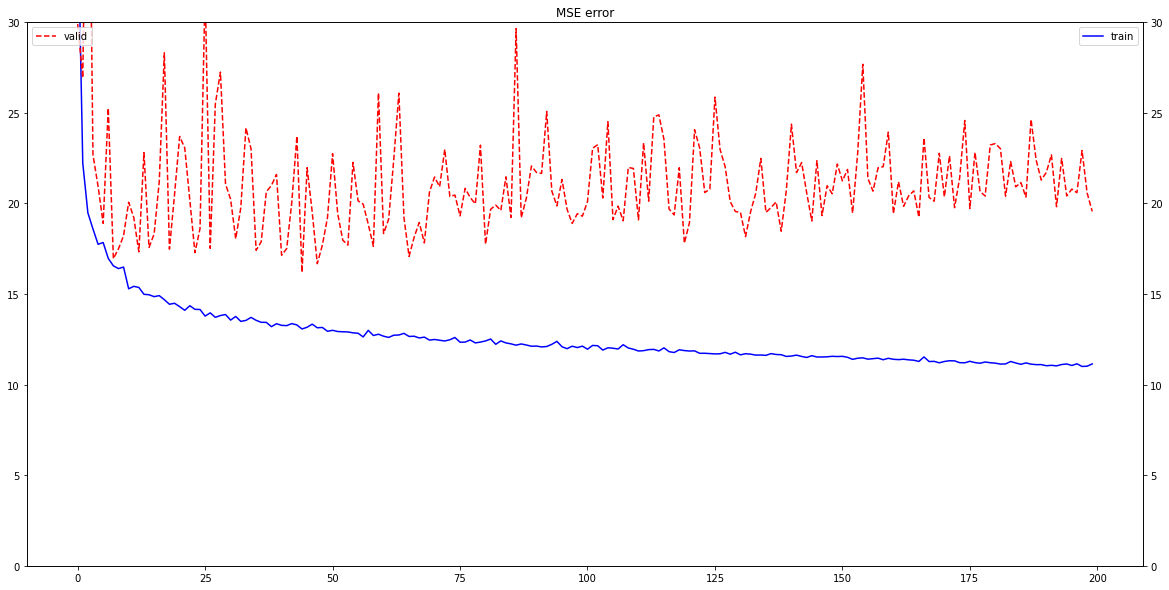

In [161]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(train_mse_list, ls='-', color='blue', label='train')
ax1.set_ylim(0,30)

ax2 = ax1.twinx()
ax2.plot(valid_mse_list, ls='--', color='red', label='valid')
ax2.set_ylim(0,30)

ax1.set_title('MSE error')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()


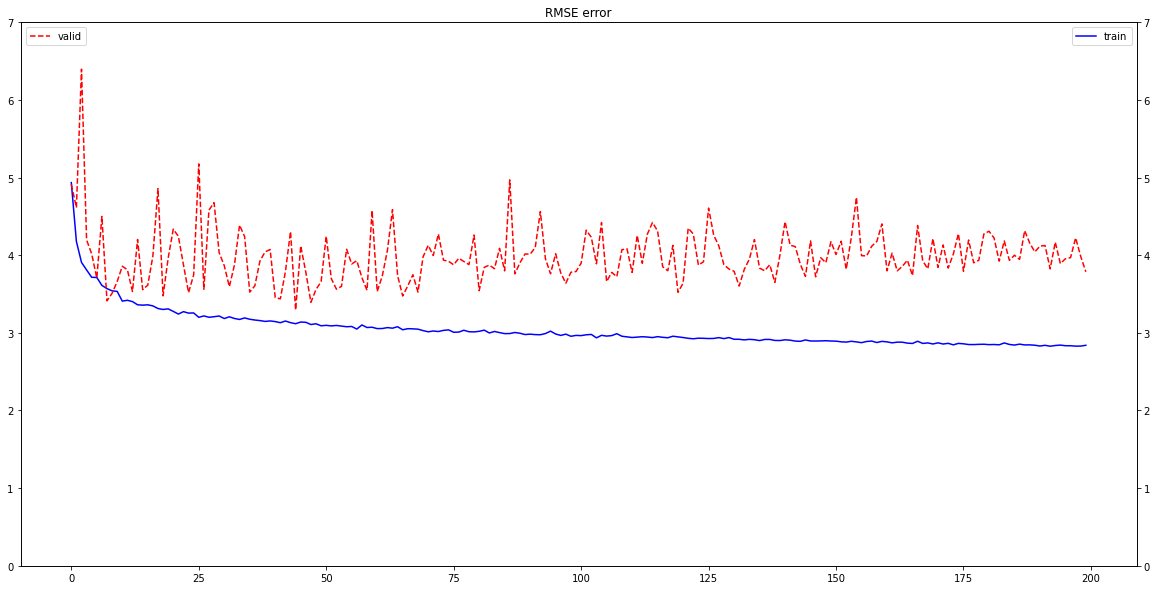

In [162]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(train_rmse_list, ls='-', color='blue', label='train')
ax1.set_ylim(0,7)
ax2 = ax1.twinx()
ax2.plot(valid_rmse_list, ls='--', color='red', label='valid')
ax2.set_ylim(0,7)
ax1.set_title('RMSE error')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()

# Predict Test

In [163]:
# 가중치 가져오기
model = DistanceEstimator()
model.load_state_dict(torch.load('./weights/ODD_basic_batch.pth'))
model.eval()
model.to(device)

DistanceEstimator(
  (model): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=1024, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=256, bias=True)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear(in_features=128, out_features=64, bias=True)
    (19): ReLU()
    (20): Linear(in_features=64, out_features=32, bias=True)
    (21): ReLU()
    (22): Linear(in_features=32, out_features=16, bias=True)
    (23): ReLU()
    (24): Linear

In [164]:
test_mse, test_rmse = evaluate(model, test_dataloader)
print('Test MSE: {:4f} \t Test RMSE: {:4f}'.format(test_mse, test_rmse))

Test MSE: 14.907510 	 Test RMSE: 3.171425


In [134]:
predict_zloc = model(torch.FloatTensor(df_test[variable].values).to(device))

In [165]:
df_test['predict'] = predict_zloc.cpu().detach().numpy()
df_test[['zloc','predict']].head(50)

,zloc,predict
0,44.91,45.053768
1,33.82,35.686333
2,3.98,4.592454
3,11.39,12.482031
4,13.04,13.171516
5,21.00,20.572550
6,21.09,19.990051
7,48.50,42.884384
8,22.45,23.891405
9,51.44,53.087433


from sklearn.metrics import mean_squared_error
def train_model(model, train_dataloader, valid_dataloader, loss_fn, lr=1e-5, batch_size=512, epochs=100, validate=False):

  
  # Convert model parameters and buffers to CPU or Cuda
  model.to(device)

  best_rmse = np.Inf
  print("Begin training...") 
  for epoch in range(1, epochs+1): 
    running_train_loss = 0.0 
    running_rmse = 0.0 
    running_vall_loss = 0.0 
    total = 0 

    for batch_ind, samples in enumerate(train_dataloader):
      x_train, y_train = samples
      optimizer.zero_grad()
      pred = model.forward(x_train)
      train_loss = loss_fn(pred, y_train)
      train_loss.backward()
      optimizer.step()
      running_train_loss += train_loss.item()

    train_loss_value = running_train_loss/len(train_dataloader)
    with torch.no_grad(): 
      model.eval() 
      for data in valid_dataloader: 
        inputs, outputs = data 
        predicted_outputs = model(inputs) 
        val_loss = loss_fn(predicted_outputs, outputs) 
      
        # The label with the highest value will be our prediction 
        running_vall_loss += val_loss.item()  
        total += outputs.size(0) 
        rmse = mean_squared_error(outputs, predicted_outputs)**0.5
        running_rmse += rmse

    # Calculate validation loss value 
    val_loss_value = running_vall_loss/len(valid_dataloader)  
    rmse = running_rmse / total

    if rmse < best_rmse:
      saveModel(model)
      best_rmse = rmse

    # Print the statistics of the epoch 
    print('Epoch {0}/{1} - loss: {2:.4f} / val_loss: {3:.4f} - RMSE: {4:.4f}'.format(epoch, epochs, train_loss_value, val_loss_value,rmse))

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
train_dataloader = DataLoader(train_dataset, batch_size=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

model = DistanceEstimator()
#optimizer = torch.optim.Adam(model.parameters, lr=1e-5)
loss_func = nn.MSELoss()

train_model(model, train_dataloader, valid_dataloader, loss_func, epochs=100, batch_size=2048)

##Predict

def predict(test_dataloader): 
    # Load the model that we saved at the end of the training loop 
    model = DistanceEstimator()
    path = "NetModel.pth" 
    model.load_state_dict(torch.load(path)) 
     
    running_rmse = 0 
    total = 0 
    pred = []
 
    with torch.no_grad(): 
      for data in test_dataloader: 
        inputs, outputs = data 
        outputs = outputs.to(torch.float32) 
        predicted_outputs = model(inputs) 
        pred.append(float(predicted_outputs))
        total += outputs.size(0) 
        rmse = mean_squared_error(outputs, predicted_outputs)**0.5
        running_rmse += rmse
 
      print('RMSE:',running_rmse / total)
    return pred

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=2)

pred = predict(test_dataset)

#Result with prediction
df_test['zloc_pred'] = pred
df_test

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

randomfores_mode

In [ ]:
class PositionwiseFeedForward(nn.Module):
    
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


In [ ]:
class PositionwiseFeedForward(nn.Module):
    
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # '-1' means last dimension. 

        out = (x - mean) / (std + self.eps)
        out = self.gamma * out + self.beta
        return out

In [ ]:
class ScaleDotProductAttention(nn.Module):
    """
    compute scale dot product attention
    Query : given sentence that we focused on (decoder)
    Key : every sentence to check relationship with Qeury(encoder)
    Value : every sentence same with Key (encoder)
    """

    def __init__(self):
        super(ScaleDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None, e=1e-12):
        # input is 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. dot product Query with Key^T to compute similarity
        k_t = k.transpose(2, 3)  # transpose
        score = (q @ k_t) / math.sqrt(d_tensor)  # scaled dot product

        # 2. apply masking (opt)
        if mask is not None:
            score = score.masked_fill(mask == 0, -e)

        # 3. pass them softmax to make [0, 1] range
        score = self.softmax(score)

        # 4. multiply with Value
        v = score @ v

        return v, score

In [ ]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v, mask=mask)

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        # 5. visualize attention map
        # TODO : we should implement visualization

        return out

    def split(self, tensor):
        """
        split tensor by number of head
        :param tensor: [batch_size, length, d_model]
        :return: [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.size()

        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor).transpose(1, 2)
        # it is similar with group convolution (split by number of heads)

        return tensor

    def concat(self, tensor):
        """
        inverse function of self.split(tensor : torch.Tensor)
        :param tensor: [batch_size, head, length, d_tensor]
        :return: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor

In [ ]:
class PostionalEncoding(nn.Module):


    def __init__(self, d_model, max_len, device):
        super(PostionalEncoding, self).__init__()

        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))


    def forward(self, x):

        batch_size, seq_len = x.size()


        return self.encoding[:seq_len, :]

In [ ]:
class TokenEmbedding(nn.Embedding):
    """
    Token Embedding using torch.nn
    they will dense representation of word using weighted matrix
    """

    def __init__(self, vocab_size, d_model):
        """
        class for token embedding that included positional information
        :param vocab_size: size of vocabulary
        :param d_model: dimensions of model
        """
        super(TokenEmbedding, self).__init__(vocab_size, d_model, padding_idx=1)

In [ ]:
class TransformerEmbedding(nn.Module):

    def __init__(self, vocab_size, d_model, max_len, drop_prob, device):
        
        super(TransformerEmbedding, self).__init__()
        self.tok_emb = TokenEmbedding(vocab_size, d_model)
        self.pos_emb = PostionalEncoding(d_model, max_len, device)
        self.drop_out = nn.Dropout(p=drop_prob)

    def forward(self, x):
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(x)
        return self.drop_out(tok_emb + pos_emb)



In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        max_len=max_len,
                                        vocab_size=enc_voc_size,
                                        drop_prob=drop_prob,
                                        device=device)

        self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

    def forward(self, x, s_mask):
        x = self.emb(x)

        for layer in self.layers:
            x = layer(x, s_mask)

        return x


class Decoder(nn.Module):
    def __init__(self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        drop_prob=drop_prob,
                                        max_len=max_len,
                                        vocab_size=dec_voc_size,
                                        device=device)

        self.layers = nn.ModuleList([DecoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

        self.linear = nn.Linear(d_model, dec_voc_size)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        trg = self.emb(trg)

        for layer in self.layers:
            trg = layer(trg, enc_src, trg_mask, src_mask)

        # pass to LM head
        output = self.linear(trg)
        return output

In [ ]:
class Transformer(nn.Module):
    
    def __init__(self, src_pad_idx, trg_pad_idx, trg_sos_idx, enc_voc_size, dec_voc_size, d_model, n_head, max_len,
                 ffn_hidden, n_layers, drop_prob, device):
        super().__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        self.device = device
        self.encoder = Encoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               enc_voc_size=enc_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

        self.decoder = Decoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               dec_voc_size=dec_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

    def forward(self, src, trg):
        src_mask = self.make_pad_mask(src, src)

        src_trg_mask = self.make_pad_mask(trg, src)

        trg_mask = self.make_pad_mask(trg, trg) * \
                   self.make_no_peak_mask(trg, trg)

        enc_src = self.encoder(src, src_mask)
        output = self.decoder(trg, enc_src, trg_mask, src_trg_mask)
        return output

    def make_pad_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # batch_size x 1 x 1 x len_k
        k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # batch_size x 1 x len_q x len_k
        k = k.repeat(1, 1, len_q, 1)

        # batch_size x 1 x len_q x 1
        q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
        # batch_size x 1 x len_q x len_k
        q = q.repeat(1, 1, 1, len_k)

        mask = k & q
        return mask

    def make_no_peak_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # len_q x len_k
        mask = torch.tril(torch.ones(len_q, len_k)).type(torch.BoolTensor).to(self.device)

        return mask